# Todo junto

Volvemos a crear una red para entrenarla en el conjunto de datos `CIFAR-10` para hacer un resumen de lo que hemos aprendido y reforzar los conocimientos

## Datasets, Dataloaders y transformaciones

Necesitamos crear un dataset, podemos hacerlo descargándo el conjunto de datos de Pytorch. O también podemos crear el dataset desde cero

Una vez tenemos el dataset, podemos dividirlo en batches para el entrenamiento.

Además a la hora de crear el dataset, podemos hacer transformaciones de los datos que nos vengan bien para el entrenamiento

In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
from torch.utils.data import DataLoader

BS = 64

train_dataloader = DataLoader(training_data, batch_size=BS, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BS, shuffle=True)

## Red neuronal (modelo)

Definimos e instanciamos nuestra red neuronal. Podemos crearla desde cero o meadiante transfer learning.

Si tenemos una GPU podemos llevarnos la red a la GPU para que el entrenamiento sea más rápido

In [3]:
from torch import nn

# Creamos la red neuronal desde cero
class NeuralNetworkFromScratch(nn.Module):
    def __init__(self):
        super(NeuralNetworkFromScratch, self).__init__()   # Se inicializa el módulo nn.Module
        self.flatten = nn.Flatten()             # Se crea una primera capa que aplana la imagen de entrada
        self.linear_relu_stack = nn.Sequential( # Se crea una módulo de arquitectura secuencial:
            nn.Linear(3*32*32, 512),                # Se añade una primera capa lineal que está preparada 
                                                    # para que le entre un vector de 3x32x32 (3072)
                                                    # y sacará un vector de 512
            nn.ReLU(),                              # Se añade una no linealidad
            nn.Linear(512, 512),                    # Se añade una segunda capa lineal que le entran 512 
                                                    # datos y saca 512 datos
            nn.ReLU(),                              # Se añade una no linealidad
            nn.Linear(512, 10)                      # Se añade una tercera capa lineal que le entran 512 
                                                    # datos y saca un array de tamaño 10 (el número
                                                    # de etiquetas)
        )
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)                         # Se pasa la imagen por la capa de aplanado
        logits = self.linear_relu_stack(x)          # Se pasa el vector resultante por la red
        #probs = self.softmax(logits)
        return logits

model_scratch = NeuralNetworkFromScratch()

In [4]:
import torch

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

model_scratch.to(device)

Using cuda device


NeuralNetworkFromScratch(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

## Función de pérdida y optimizador

Definimos una función de pérdida y un optimizador

In [5]:
LR = 1e-2

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_scratch.parameters(), lr=LR)


## Ciclo de entrenamiento

Entrenamos la red

In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # X and y to device
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            # X and y to device
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [7]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model_scratch, loss_fn, optimizer)
    test_loop(test_dataloader, model_scratch, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306402  [    0/50000]
loss: 2.259025  [ 6400/50000]
loss: 2.174863  [12800/50000]
loss: 2.117852  [19200/50000]
loss: 2.023432  [25600/50000]
loss: 2.031960  [32000/50000]
loss: 1.988318  [38400/50000]
loss: 2.056397  [44800/50000]
Test Error: 
 Accuracy: 28.1%, Avg loss: 1.965780 

Epoch 2
-------------------------------
loss: 1.985560  [    0/50000]
loss: 1.929681  [ 6400/50000]
loss: 1.771994  [12800/50000]
loss: 1.947874  [19200/50000]
loss: 1.875200  [25600/50000]
loss: 1.662335  [32000/50000]
loss: 1.626034  [38400/50000]
loss: 1.723350  [44800/50000]
Test Error: 
 Accuracy: 35.3%, Avg loss: 1.846561 

Epoch 3
-------------------------------
loss: 1.876759  [    0/50000]
loss: 1.929100  [ 6400/50000]
loss: 1.805240  [12800/50000]
loss: 1.840645  [19200/50000]
loss: 1.705923  [25600/50000]
loss: 1.781176  [32000/50000]
loss: 1.817811  [38400/50000]
loss: 1.664451  [44800/50000]
Test Error: 
 Accuracy: 35.1%, Avg loss: 1.807358 

Epoc

## Guardar o exportar el modelo

Podemos guardar o exportar el modelo

In [8]:
import torch.onnx as onnx

# Pesos
path = "data/pesos.pth"
torch.save(model_scratch.state_dict(), path)

# Red
path = "data/modelo.pth"
torch.save(model_scratch, path)

# Zip
path = "data/modelo.zip"
torch.jit.save(torch.jit.script(model_scratch.cpu()), path)

# ONNX
path = "data/modelo.onnx"
batch = 8
input_image = torch.rand((batch,3,32,32))
model_scratch.to('cpu')
onnx.export(model_scratch, input_image, 'model.onnx')

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



## Cargar el modelo

Podemos cargar el modelo guardado previamente

In [9]:
from torch import load

# Pesos
path = "data/pesos.pth"
model_scratch.load_state_dict(load(path))

# Red
path = "data/modelo.pth"
model_scratch = load(path)

# Zip
path = "data/modelo.zip"
model_scratch = torch.jit.load(path)

## Inferencia

Una vez tenemos nuestra red entrenada la podemos usar para hacer predicciones

In [10]:
# Cogemos una muestra al azahar
sample_dataloader = next(iter(train_dataloader))
sample_dataloader_images, sample_dataloader_labels = sample_dataloader

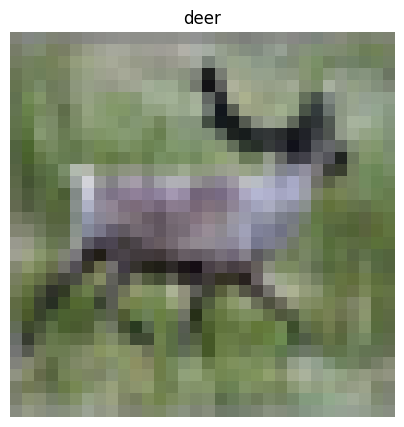

In [13]:
from random import randint, seed
import matplotlib.pyplot as plt

# Generamos una semilla fija para poder repetir el ejemplo
seed(10)

idx = randint(0, len(sample_dataloader_images)-1)
sample_image = sample_dataloader_images[idx]
sample_label = sample_dataloader_labels[idx]

labels_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

figure = plt.figure(figsize=(5, 5))
plt.title(labels_map[sample_label.item()])
plt.axis("off")

plt.imshow(sample_image.permute(1,2,0).squeeze())  
# permute cambia el orden de las dimensiones, ya que las
# imágenes tienen tamaño 3x32x32, pero necesitamos que
# las dimensiones sean 32x32x3 para que matplotlib las pinte
# así que se permutan poniendo primero las dos de 32 y 
# la última la de 3

# squeeze elimina todas las dimensiones 1 de un tensor, 
# si se le mete un tensor de dimensiones (Ax1xBxCx1xD) 
# devuelve un tensor de dimensiones (AxBxCxD)

In [14]:
# Le pasamos la imagen a la red neuronal creada desde cero
model_scratch.to("cpu")
logits_scratch = model_scratch(sample_dataloader_images)

# La red ha devuelto 64 logits, por lo que nos quedamos con el 
# número idx que es el que se ha representado antes
probs_scratch = logits_scratch.softmax(dim=1)
label = probs_scratch[idx].argmax().item()
print(f"La red cree que en la imagen hay {labels_map[label]}")

La red cree que en la imagen hay deer
